# Referrence irradiance dataset

This notebook documents the quality control and subsequent removal of erroneous data in the 1976 Barstow irradiance dataset, which has been adopted as the de-facto standard dataset for shading studies of two-axis tracking collectors.

The dataset contains 15-min measurements from 1976 of the irradiance components: global horizontal irradiance (GHI) and direct normal irradiance (DNI). The dataset is available from the National Renewable Energy Laboratory (NREL) and can be downloaded [here](https://www.nrel.gov/grid/solar-resource/assets/data/f06.txt). Apley (1979) was the first to use this dataset and it has since been used in numerous studies (e.g., Cumpston and Pye, 2014; Meller, 2010; Pons and Dugan, 1984; Osborn, 1980).

However, the dataset contains many periods with erroneous and invalid data (e.g., periods of unfeasible high irradiance values, incorrect tracking, and irradiance at night). Particularly, the measurements of DNI were prone to errors, which is the main irradiance component utilized by two-axis tracking collectors. As noted by Meller, Y (2010), different studies report different annual shading values using the dataset, which is "believed to be due to the different treatment of missing irradiance data." It is the aim of this notebook to provide a quality-controlled version of the 1976 Barstow dataset that can be used as reference in future studies.

Import necessary libraries:

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import pvlib
import matplotlib.dates as mdates

<br>

Define the location as a pvlib `Location` object (Barstow, California):

In [2]:
barstow = pvlib.location.Location(latitude=34.88, longitude=-117.00, altitude=664, name='Barstow', tz='Etc/GMT+8')

## Load the dataset
The original dataset is a fixed-width-file (fwf), whih can be conveniently parsed using the pandas `read_fwf` function:

In [13]:
data_url = 'https://www.nrel.gov/grid/solar-resource/assets/data/f06.txt'

# Read file as a fixed-with-file (fwf)
df_barstow = pd.read_fwf(data_url, skiprows=[0,2])

# Only keep data from 1976
df_barstow = df_barstow[df_barstow['Yr'] == '76']

df_barstow.head()

,Yr,Mo,Dy,Hr,Mn,Glo Hor,Dir Nor,Temp
0,76,1,1,0,15,0.88,0.94,-1.59
1,76,1,1,0,30,0.00,0.94,-1.94
2,76,1,1,0,45,0.88,1.88,-2.36
3,76,1,1,1,0,0.00,0.94,-2.50
4,76,1,1,1,15,0.88,0.00,-2.78


<br>

Next, we set the index to datetime:

In [14]:
# This step requires defining a custom function (*convert_to_datetime*) for converting
# the timestamps to datetime, as the time timestamps do not following the ISO convention
# for denoting midnight as 00:00, but rather represents midnight as 24:00.
def convert_to_datetime(time):
    """Convert string with instances of midnight as
    24:00 (un-parsable) to 00:00 (parsable)
    """
    frmt = '%y %m %d--%H %M'
    try:
        time = dt.datetime.strptime(time, frmt)
    except ValueError:
        time = time.replace('--24', '--23')
        time = dt.datetime.strptime(time, frmt)
        time += dt.timedelta(hours=1)
    return time

# Set date and time as index
df_barstow.index = (df_barstow[['Yr', 'Mo', 'Dy']].apply(' '.join, 1)
                    + '--' + df_barstow[['Hr', 'Mn']].apply(' '.join, 1))\
                    .apply(convert_to_datetime)

# Drop time and date columns
df_barstow = df_barstow.drop(columns=['Yr', 'Mo', 'Dy', 'Hr', 'Mn'])
# Localize index to the local timezone
df_barstow.index = df_barstow.index.tz_localize(barstow.tz)
df_barstow.head()

,Glo Hor,Dir Nor,Temp
1976-01-01 00:15:00-08:00,0.88,0.94,-1.59
1976-01-01 00:30:00-08:00,0.00,0.94,-1.94
1976-01-01 00:45:00-08:00,0.88,1.88,-2.36
1976-01-01 01:00:00-08:00,0.00,0.94,-2.50
1976-01-01 01:15:00-08:00,0.88,0.00,-2.78


<br>

Next, the columns are renamed in order to conform to the standard pvlib names:

In [17]:
# Rename column names to pvlib names
df_barstow = df_barstow.rename(
    columns={'Glo Hor': 'ghi', 'Dir Nor': 'dni', 'Temp': 'temp_air'})

# Convert column dtypes to floats
df_barstow = df_barstow.astype(float)

df_barstow.head()

,ghi,dni,temp_air
1976-01-01 00:15:00-08:00,0.88,0.94,-1.59
1976-01-01 00:30:00-08:00,0.00,0.94,-1.94
1976-01-01 00:45:00-08:00,0.88,1.88,-2.36
1976-01-01 01:00:00-08:00,0.00,0.94,-2.50
1976-01-01 01:15:00-08:00,0.88,0.00,-2.78


<br>

Calculate the solar postion and extraterrestrial radiation using pvlib:

In [18]:
# Calculate the solar position
df_barstow = pd.concat([df_barstow, barstow.get_solarposition(df_barstow.index)], axis='columns')
# Calculate extraterrestrial radiation
df_barstow['dni_extra'] = pvlib.irradiance.get_extra_radiation(df_barstow.index)

df_barstow.head()

,ghi,dni,temp_air,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
1976-01-01 00:15:00-08:00,0.88,0.94,-1.59,167.092519,167.092519,-77.092519,-77.092519,25.278534,-3.192970,1413.981805
1976-01-01 00:30:00-08:00,0.00,0.94,-1.94,165.467857,165.467857,-75.467857,-75.467857,38.153710,-3.197945,1413.981805
1976-01-01 00:45:00-08:00,0.88,1.88,-2.36,163.355080,163.355080,-73.355080,-73.355080,48.333521,-3.202919,1413.981805
1976-01-01 01:00:00-08:00,0.00,0.94,-2.50,160.917391,160.917391,-70.917391,-70.917391,56.311453,-3.207892,1413.981805
1976-01-01 01:15:00-08:00,0.88,0.00,-2.78,158.265917,158.265917,-68.265917,-68.265917,62.652770,-3.212865,1413.981805


## Removal of erroneous data

The removal of erroneous data has been done by manually inspecting each day.

The identified erroneous values are set to nan:

In [19]:
# Make of copy of the original dataframe
df = df_barstow.copy()

df.loc['1976-01-21 12:00':'1976-01-21 12:30', 'dni'] = np.nan
df.loc['1976-02-12 11:30':'1976-02-12 11:45', 'dni'] = np.nan
df.loc['1976-02-12 09:45':'1976-02-12 10:45', 'ghi'] = np.nan
df.loc['1976-02-20 12:15':'1976-02-20 12:30', 'dni'] = np.nan
df.loc['1976-02-21 12:45':'1976-02-21 13:00', 'dni'] = np.nan
df.loc['1976-03-12 10:15':'1976-03-12 14:15', 'dni'] = np.nan
df.loc['1976-03-13 10:15':'1976-03-13 13:00', 'dni'] = np.nan
df.loc['1976-03-30 11:00':'1976-03-30 12:30', 'dni'] = np.nan
df.loc['1976-05-04 12:15', 'ghi'] = np.nan
df.loc['1976-05-11 12:30':'1976-05-13 08:00',  ['ghi','dni']] = np.nan  # three day period with constant high values
df.loc[['1976-05-17 11:30','1976-05-17 12:30'], 'ghi'] = np.nan  # two large downwards spikes in ghi
df.loc['1976-05-18 12:15':'1976-05-18 12:45', 'ghi'] = np.nan  # period with unresonable low values of ghi
df.loc['1976-05-19 11:45', 'ghi'] = np.nan
df.loc['1976-05-21 11:45':'1976-05-21 12:15', 'ghi'] = np.nan
df.loc['1976-05-28 11:00':'1976-05-28 12:30', 'ghi'] = np.nan
df.loc['1976-06-03 11:30':'1976-06-03 12:30', 'ghi'] = np.nan
df.loc['1976-06-05 11:30':'1976-06-05 12:30', 'ghi'] = np.nan
df.loc['1976-06-06 12:15', 'ghi'] = np.nan
df.loc['1976-06-08 12:30':'1976-06-08 12:45', 'ghi'] = np.nan
df.loc['1976-06-10 12:30', 'ghi'] = np.nan
df.loc['1976-06-13 12:45':'1976-06-13 13:00', 'ghi'] = np.nan
df.loc['1976-06-15 11:45':'1976-06-15 12:15', 'ghi'] = np.nan
df.loc['1976-06-16 16:30':'1976-06-17 15:00', 'dni'] = np.nan  # long period of zero dni
df.loc['1976-06-22 12:00':'1976-06-22 12:15', 'ghi'] = np.nan
df.loc['1976-06-23 11:45':'1976-06-23 12:30', 'ghi'] = np.nan
df.loc['1976-06-24 11:30':'1976-06-24 12:45', 'ghi'] = np.nan
df.loc['1976-06-25 10:15':'1976-06-25 14:45', 'dni'] = np.nan
df.loc['1976-06-26 11:45':'1976-06-26 12:15', 'ghi'] = np.nan
df.loc['1976-06-29 13:15', 'ghi'] = np.nan
df.loc['1976-06-30 08:00':'1976-06-30 15:30', 'dni'] = np.nan
df.loc['1976-07-01 11:45':'1976-07-01 12:30', 'ghi'] = np.nan
df.loc['1976-07-15 11:45':'1976-07-15 12:30', 'ghi'] = np.nan
df.loc['1976-07-27 11:30', 'ghi'] = np.nan
df.loc['1976-07-29 11:45':'1976-07-29 13:15', 'ghi'] = np.nan
df.loc['1976-08-12 11:00':'1976-08-12 11:30', 'dni'] = np.nan
df.loc['1976-08-18 00:00':'1976-08-19 14:15', 'dni'] = np.nan
df.loc['1976-08-31 00:00':'1976-09-01 14:00', 'dni'] = np.nan
df.loc['1976-09-07 10:30':'1976-09-13 15:15', 'dni'] = np.nan
#df.loc['1976-09-29 00:00':'1976-09-29 23:45', 'dni'] = np.nan  # questionable, will not flag
df.loc['1976-10-19 00:00':'1976-10-20 09:30', 'dni'] = np.nan
df.loc['1976-10-20 13:45':'1976-10-21 23:45', 'dni'] = np.nan
df.loc['1976-11-19 09:30':'1976-11-19 10:30', 'dni'] = np.nan
df.loc['1976-11-27 00:00':'1976-12-02 10:15', 'dni'] = np.nan
df.loc['1976-12-09 00:15':'1976-12-10 00:00', 'dni'] = np.nan
df.loc['1976-12-13 00:15':'1976-12-15 00:00', 'dni'] = np.nan
df.loc['1976-12-18 00:15':'1976-12-20 00:00', 'dni'] = np.nan

<br>

Derive irradiance values:

In [25]:
df['dni_inplane'] = (df['dni'] * np.cos(np.deg2rad(df['apparent_zenith']))).clip(lower=0)
df['dhi'] = (df['ghi'] - df['dni_inplane']).clip(lower=0)

# Calculate normalized irradiance values
df['Kn'] = df['dni'] / df['dni_extra']
df['K'] = df['dhi'] / df['ghi']
df['Kt'] = df['ghi'] / (df['dni_extra'] * np.cos(np.deg2rad(df['apparent_zenith']))).clip(lower=0)

## Visualization of irradiance time series
As a final step it is a good idea to visualize the data in order to get an idea of how much and where data is missing and as a general check that there is not any obvious bad data.

### 2D visualization as function of time and date

One helpful plot to visualize the available data is a 2D plot of solar irradiance as a heat map as a function of time of day vs. day of the year.

Notice how especially the DNI is higher near the sunset times than the sunrise times. This significes that the timestamp refers to the past 15 minutes.

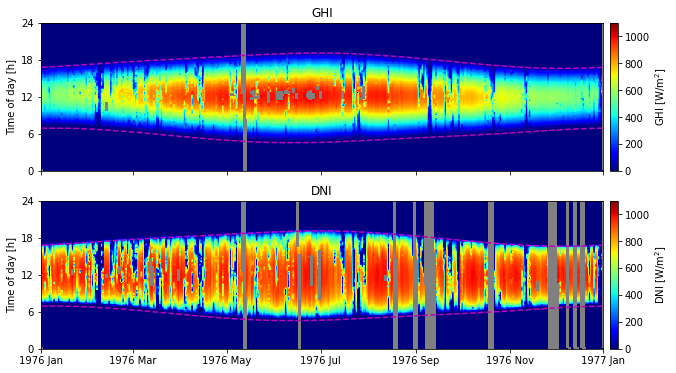

In [26]:
# 2D plot of GHI & DNI where y-axis is hours and x-axis is day
df_2d = df[['ghi','dni']].set_index([df.index.date, df.index.hour*60+df_barstow.index.minute]).unstack(level=0)
df_2d = df_2d.reindex(np.arange(0, 1440,15)) # ensure all minutes are present
df_2d.index = df_2d.index/60 # necessary to first convert afterwards, due to rounding issues.

# Calculate sunrise times
days = pd.date_range(df.index[0], df.index[-1], tz=barstow.tz) # List of days for which to calculate sunrise/sunset
sunrise_sunset = barstow.get_sun_rise_set_transit(days, method='spa')

# Convert sunrise/sunset from Datetime to hours (decimal)
sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.hour + sunrise_sunset['sunrise'].dt.minute/60
sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.hour + sunrise_sunset['sunset'].dt.minute/60

# Calculate the extents of the 2D plot, in the format [x_start, x_end, y_start, y_end]
xlims = mdates.date2num([df_barstow.index[0].date(), df_barstow.index[-1].date()])
extent = [xlims[0], xlims[1], 0, 24]

fig, axes = plt.subplots(nrows=2, figsize=(12,6), sharex=True)
for ax, component in zip(axes, ['ghi','dni']): # names of plot
    im = ax.imshow(df_2d[component], aspect='auto', origin='lower', cmap='jet',
                   extent=extent, vmin=0, vmax=1100)
    ax.set_title(component.upper())
    ax.set_xlim(xlims)
    ax.set_yticks(np.arange(0,25,6))
    ax.set_ylabel('Time of day [h]')
    ax.set_facecolor('grey')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
    ax.plot(mdates.date2num(sunrise_sunset.index), sunrise_sunset[['sunrise', 'sunset']], 'm--')
    cbar1 = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.01, label=f"{component.upper()} [W/m$^2$]")

### Visualization as function of solar elevation and zenith angle 

In order to detect possible shading from nearby objects and hills, it is useful to visualize the maximum irradiance as a function of solar elevation and zenith angle. Particularly the DNI plot is helpful in identifiying the local obstruction free horizon line.

Due to the 15-minute resolution a 2-degree angle resolution is used.

Text(0.5, 1.0, 'Maximum irradiance as a function of solar elevation and azimuth')

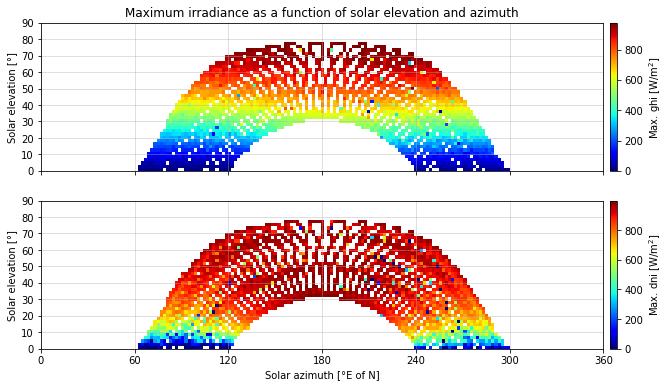

In [27]:
df_2d = df.loc[df['apparent_elevation']>=0, ['ghi','dni']].groupby([df['azimuth'].divide(2).round(0).multiply(2), df['apparent_elevation'].divide(2).round(0).multiply(2)]).max().unstack(level=0).sort_index()

fig, axes = plt.subplots(nrows=2, figsize=(12,6), sharex=True)
for ax, component in zip(axes, ['ghi','dni']):
    extent = [df_2d[component].columns.min(), df_2d[component].columns.max(), df_2d[component].index.min(), df_2d[component].index.max()]
    im = ax.imshow(df_2d.loc[0:, component], aspect='auto', origin='lower', cmap='jet',
                        extent=extent, vmin=0, vmax=df_barstow[component].quantile(0.99))
    ax.grid(alpha=0.5)
    ax.set_xlim(0,360)
    ax.set_xticks(np.arange(0,360+60,60))
    ax.set_yticks(np.arange(0,round(df_2d.index.max()/10)*10+10+10,10))
    ax.set_ylim(0,None)
    ax.set_ylabel('Solar elevation [°]')
    cbar3 = fig.colorbar(im, ax=ax, pad=0.01, orientation='vertical', label='Max. {} [W/m$^2$]'.format(component))
axes[-1].set_xlabel('Solar azimuth [°E of N]')
axes[0].set_title('Maximum irradiance as a function of solar elevation and azimuth')

Based on the plots above, it seems that the local shading is limited to below 10° solar elevation.

### Quality-check plots

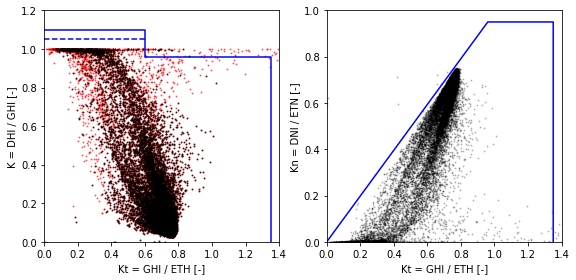

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
df.plot.scatter(ax=axes[0], x='Kt', y='K', s=1, c='r', alpha=0.5)
df[df['ghi']>50].plot.scatter(ax=axes[0], x='Kt', y='K', s=1, c='k', alpha=0.5)

axes[0].set_xlim(0, 1.4), axes[0].set_ylim(0, 1.2)
axes[0].plot([0,0.6,0.6,1.35,1.35], [1.1,1.1,0.96,0.96,0], c='blue', label='limits')
axes[0].plot([0,0.6], [1.05,1.05], c='blue', linestyle='dashed', label='limits')
axes[0].set_xlabel('Kt = GHI / ETH [-]'), axes[0].set_ylabel('K = DHI / GHI [-]')


df.plot.scatter(ax=axes[1], x='Kt', y='Kn', s=1, c='k', alpha=0.2)
axes[1].set_xlim(0, 1.4), axes[1].set_ylim(0, 1)
axes[1].plot([0,0.96,1.35,1.35], [0,0.95,0.95,0], c='blue', label='limits')
axes[1].set_xlabel('Kt = GHI / ETH [-]'), axes[1].set_ylabel('Kn = DNI / ETN [-]')

plt.tight_layout()

### Percentage of missing data
It is also interesting to get a quantitative measure for the amount of missing data:

In [30]:
df.loc[df['apparent_elevation']>0, ['ghi','dni']].isna().mean().multiply(100).round(1).astype(str).add(' %')

ghi    0.9 %
dni    7.2 %
dtype: object

Clearly, the DNI measurements are errornous to a much higher degree than the GHI measurements. This can partly be due to the fact that it is much easier to detect a faulty DNI measurements, and also that the DNI sensor is much more prone to soiling and is affected by tracker errors and misalignment.

## References


Apley, W.J., 1979. SHADE - A computer model for evaluating the optical performance of two-axis tracking parabolic concentrators, in: American Society of Mechanical Engineers (Paper). pp. 1–7.

Cumpston, J., Pye, J., 2014. Shading and land use in regularly-spaced sun-tracking collectors. Sol. Energy 108, 199–209. https://doi.org/10.1016/j.solener.2014.06.012

Meller, Y., 2010. Analytically calculating shading in regular arrays of sun-pointing collectors. Sol. Energy 84, 1967–1974. https://doi.org/10.1016/j.solener.2010.08.006

Osborn, D.B., 1980. Generalized Shading Analysis for Parabolodial Collector Fields, in: Energy Technology Conference & Exhibition, American Society of Mechanical Engineers. pp. 1–8.

Pons, R.L., Dugan, A.F., 1984. The effect of concentrator field layout on the performance of point-focus distributed receiver systems. J. Sol. Energy Eng. Trans. ASME 106, 35–38. https://doi.org/10.1115/1.3267559
